<a href="https://colab.research.google.com/github/raz0208/Advance-Quantitative-Research-Project/blob/main/Task1/Natural_Gas_Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Gas Price Interpolation Forecasting
**Task1: Investigate and Analyse Gas Price data**

In [ ]:
# Import Required Libraries and Pakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load and Read dataset
df = pd.read_csv('Nat_Gas.csv')

df.head(10)

,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84
8,6/30/21,10.00
9,7/31/21,10.10


## Data Inspection And Undrestanding

In [ ]:
# Check and convert data column to date format
df['Dates'] = pd.to_datetime(df['Dates'])

# Sort the data by "date"
df = df.sort_values("Dates")

# Check for duplication
duplicates = df.duplicated().sum()

# Check for Missing Values
missing_val = df.isnull().sum()

# Print the info
print("Duplicate data = ", duplicates)
print("Missing Values = ", missing_val, "\n")

# Print summary of the dataset
summary_stats = df['Prices'].describe()
print("\nSummary statistics:\n", summary_stats, "\n")

# Print the sorted dataset
df.head(10)

Duplicate data =  0
Missing Values =  Dates     0
Prices    0
dtype: int64 


Summary statistics:
 count    48.000000
mean     11.207083
std       0.757897
min       9.840000
25%      10.650000
50%      11.300000
75%      11.625000
max      12.800000
Name: Prices, dtype: float64 



,Dates,Prices
0,2020-10-31,10.10
1,2020-11-30,10.30
2,2020-12-31,11.00
3,2021-01-31,10.90
4,2021-02-28,10.90
5,2021-03-31,10.90
6,2021-04-30,10.40
7,2021-05-31,9.84
8,2021-06-30,10.00
9,2021-07-31,10.10


#### **Natural Gas Monthly Prices (Time Series Plot)**
This shows the raw data over time. You can clearly see an upward trend (prices generally increasing from 2020 to 2024) and seasonality (prices spike in winter months and drop in summer months), which is typical for natural gas demand.

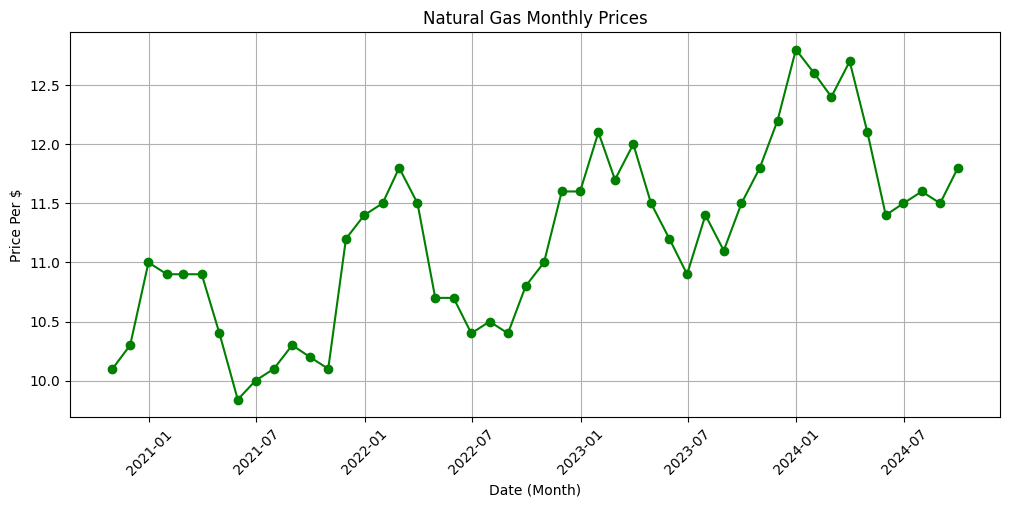

In [ ]:
# Visualise the data
plt.figure(figsize=(12, 5))
plt.plot(df['Dates'], df['Prices'], marker='o', linestyle='-', color='green')
plt.title('Natural Gas Monthly Prices')
plt.xlabel('Date (Month)')
plt.ylabel('Price Per $')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Statistical Tests & Analysis

**STL Decomposition (Trend, Seasonal, Residual):**

**Trend:** Isolates the long-term direction of the price. It confirms the steady increase in price over the years, ignoring the month-to-month volatility.

**Seasonal:** Isolates the repeating annual pattern. This confirms that gas prices follow a predictable cycle every 12 months.

**Residual:** This is the "noise" or random error left over after removing the Trend and Seasonality.


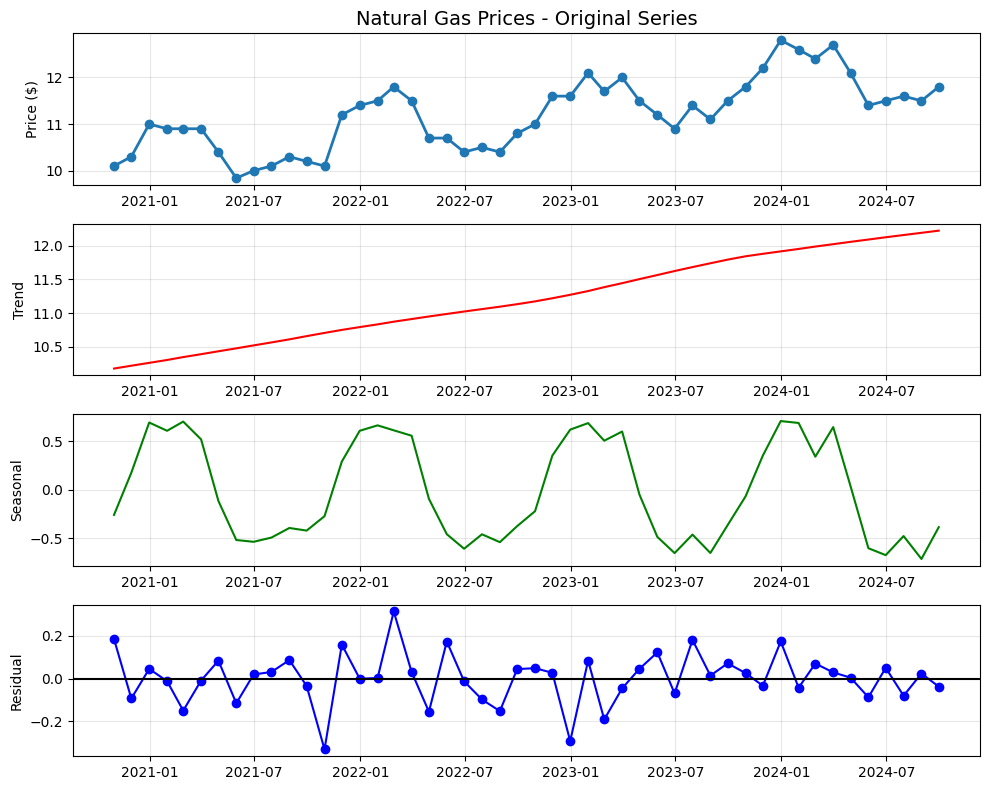

In [ ]:
# Implement Seasonal Decomposition

# Creat monthly time-indexed series
df_month = df.set_index("Dates").asfreq('M')

# Perform STL
stl = STL(df_month['Prices'], period=12)
result = stl.fit()

# Extract componenets
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Visualise decomposition
plt.figure(figsize=(10, 8))

# Original Price plot
plt.subplot(4, 1, 1)
plt.plot(df_month['Prices'], linewidth=2, marker='o')
plt.title('Natural Gas Prices - Original Series', fontsize=14)
plt.ylabel('Price ($)')
plt.grid(alpha=0.3)

# Trend plot
plt.subplot(4, 1, 2)
plt.plot(trend, color='red')
plt.title('', fontsize=14)
plt.ylabel('Trend')
plt.grid(alpha=0.3)

# Seasonal plot
plt.subplot(4, 1, 3)
plt.plot(seasonal, color='green')
plt.title('', fontsize=14)
plt.ylabel('Seasonal')
plt.grid(alpha=0.3)

# Residual plot
plt.subplot(4, 1, 4)
plt.plot(residual, color='blue', marker='o')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')
plt.title('', fontsize=14)
plt.ylabel('Residual')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical Tests & Analysis: Stationart Check

 - **ADF (Augmented Dickey-Fuller) Test Results**
   - **Conclusion:** The data is Non-Stationary.
   - **The Logic:** The Null Hypothesis ($H_0$) of the ADF test is that the data is non-stationary (has a unit root). We want to reject this to prove the data is stationary.
    - **ADF Test Result:**
      - `p-value (0.97):` This is very high (much greater than 0.05). This means you fail to reject the null hypothesis.
      - `Test Statistic (0.218):` This is higher than the critical values (-2.94, etc.).
    - **Meaning:** The statistical evidence confirms that the data has a time-dependent structure (trend/seasonality) and cannot be modeled as a stationary process without modification (like differencing).

 - **KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test Results**
 - **Conclusion:** The data is Non-Stationary.
   - **The Logic:** The Null Hypothesis ($H_0$) of the KPSS test is the opposite of ADF: it assumes the data is stationary. We want to fail to reject this to confirm stationarity.
   - **KPSS Test Result:**
     - `p-value (0.01):` This is very low (below 0.05). This means you reject the null hypothesis.
     - `Test Statistic (0.730):` This is higher than the 5% critical value (0.463).Meaning: This reinforces the ADF result. The data has a significant trend or structural break that makes the mean or variance change over time.

- **ACF (Autocorrelation Function):** This chart shows how correlated the price is with its past values. If the blue bars decrease very slowly (which they likely do here), it indicates the data is non-stationary and heavily influenced by a trend.

- **PACF (Partial Autocorrelation Function):** This shows the direct correlation between a month and a past month, removing the "middle-man" influence of the months in between. This is primarily used to determine the parameters for AR (AutoRegressive) models.

**Summary**
Both tests and the plots agree: The data is non-stationary. To predict future prices accurately using statistical models (like ARIMA), you would need to remove the trend and seasonality (e.g., by differencing the data) or use a model that explicitly handles them (like a regression model with seasonal variables).

ADF Test Results:
ADF Test Statistic: 0.21807686169999427
p-value: 0.973257438844869
Lags Used: 10
Number of Observation used: 37
Critical Value 1%: -3.6209175221605827
Critical Value 5%: -2.9435394610388332
Critical Value 10%: -2.6104002410518627


KPSS Test Results:
KPSS Test Statistic: 0.7304095231737717
p-value: 0.010780952438748024
Lags Used: 4
Critical value 10%: 0.347
Critical value 5%: 0.463
Critical value 2.5%: 0.574
Critical value 1%: 0.739




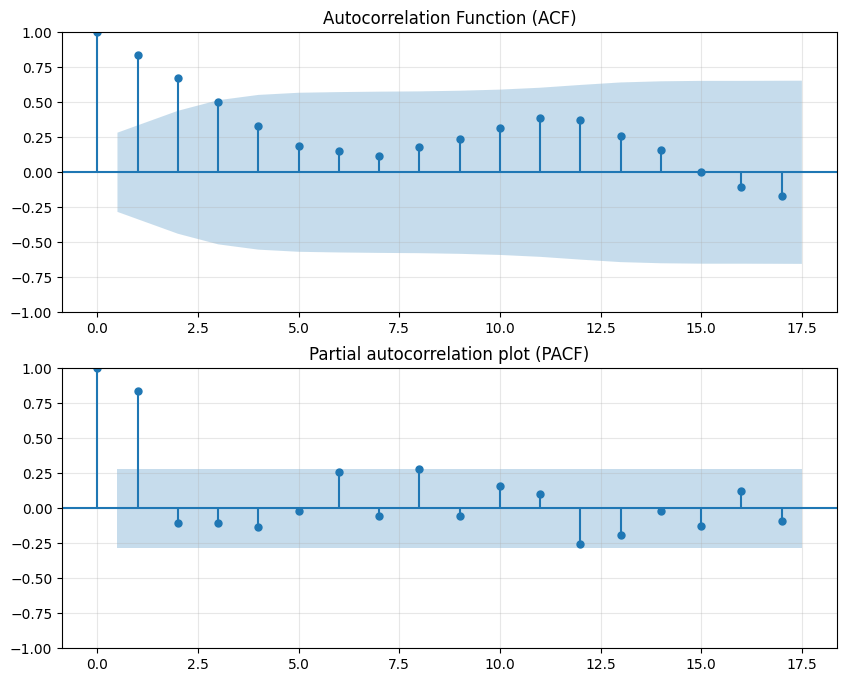

In [ ]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(df_month['Prices'].dropna())
print("ADF Test Results:")
print(f"ADF Test Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Lags Used: {adf_result[2]}")
print(f"Number of Observation used: {adf_result[3]}")
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")
print("\n")

# KPSS Test
kpss_result = kpss(df_month['Prices'].dropna(), regression='c')
print("KPSS Test Results:")
print(f"KPSS Test Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
print(f"Lags Used: {kpss_result[2]}")
for key, value in kpss_result[3].items():
  print(f"Critical value {key}: {value}")
print("\n")

# adf Visialisation
plt.figure(figsize=(10, 8))

# ACF Plot
plt.subplot(2, 1, 1)
plot_acf(df_month['Prices'], ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.grid(alpha=0.3)

# PACF Plot
plt.subplot(2, 1, 2)
plot_pacf(df_month['Prices'], ax=plt.gca())
plt.title('Partial autocorrelation plot (PACF)')
plt.grid(alpha=0.3)

plt.show()

# Model Implementation: Time Series Forcasting


## SARIMA Model

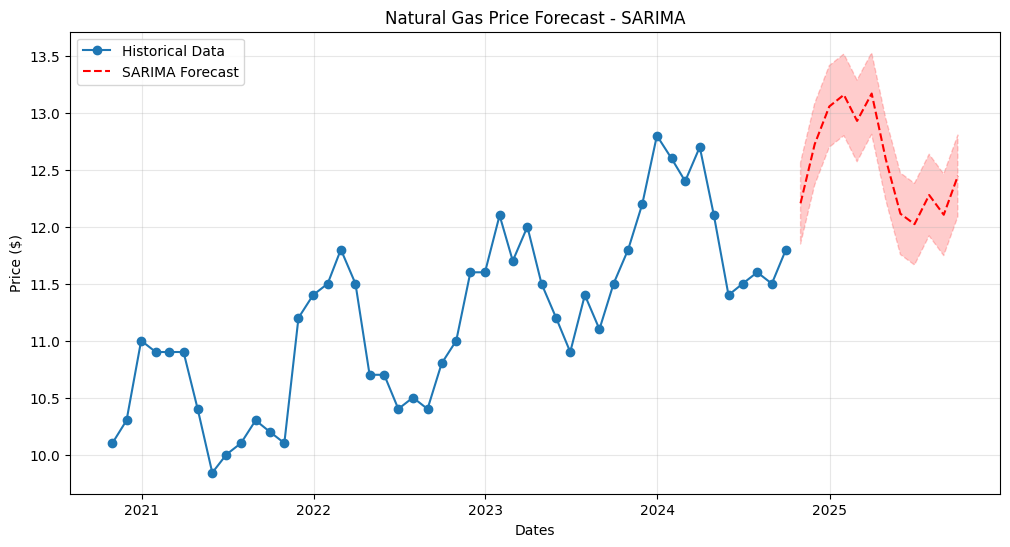


 
Forecasted Prices (Next 12 Months):
Prices           mean
2024-10-31  12.206504
2024-11-30  12.724507
2024-12-31  13.056321
2025-01-31  13.158380
2025-02-28  12.929262
2025-03-31  13.169657
2025-04-30  12.591878
2025-05-31  12.114226
2025-06-30  12.022451
2025-07-31  12.278492
2025-08-31  12.105090
2025-09-30  12.447106


In [ ]:
# Fit SARIMA Model
SARIMA_model = SARIMAX(df_month['Prices'],
                       order=(1, 1, 1), # Order (p,d,q): (1,1,1) and (0, 1, 1)
                       seasonal_order=(1, 1, 2, 12), # Seasonal Order (P,D,Q,s): (1,1,1,12), (0, 1, 1, 12), (1, 1, 0, 12), and (1, 1, 2, 12)
                       enforce_stationarity=False,
                       enforce_invertibility=False
                       )
SARIMA_result = SARIMA_model.fit()
# # Print Summary
# print(SARIMA_result.summary())

# SARIMA Model Forecast
steps = 12
SARIMA_forecast = SARIMA_result.get_forecast(steps=steps)
SARIMA_forecast_mean = SARIMA_forecast.predicted_mean
SARIMA_conf_int = SARIMA_forecast.conf_int()

SARIMA_forecast_df = SARIMA_forecast.summary_frame()

# SARIMA Model Forecasting Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df_month.index, df_month['Prices'], label='Historical Data', marker='o', linestyle='-') # Historical data
plt.plot(SARIMA_forecast_mean.index, SARIMA_forecast_mean, label='SARIMA Forecast', linestyle='--', color='red') # SARIMA Forecast
plt.fill_between(SARIMA_forecast_mean.index, SARIMA_conf_int.iloc[:, 0],
                 SARIMA_conf_int.iloc[:, 1], linestyle='--', color='red', alpha=0.2) # Confidence Interwall
plt.title('Natural Gas Price Forecast - SARIMA')
plt.xlabel('Dates')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Copy SARIMA forcast values in a dataframe
print("\n", "\nForecasted Prices (Next 12 Months):")
print(SARIMA_forecast_df[['mean']].head(12))

# Save SARIMA forcast values in a csv file
SARIMA_forecast_df[['mean']].head(12).to_csv('SARIMA_forecast.csv')


## ETS Model

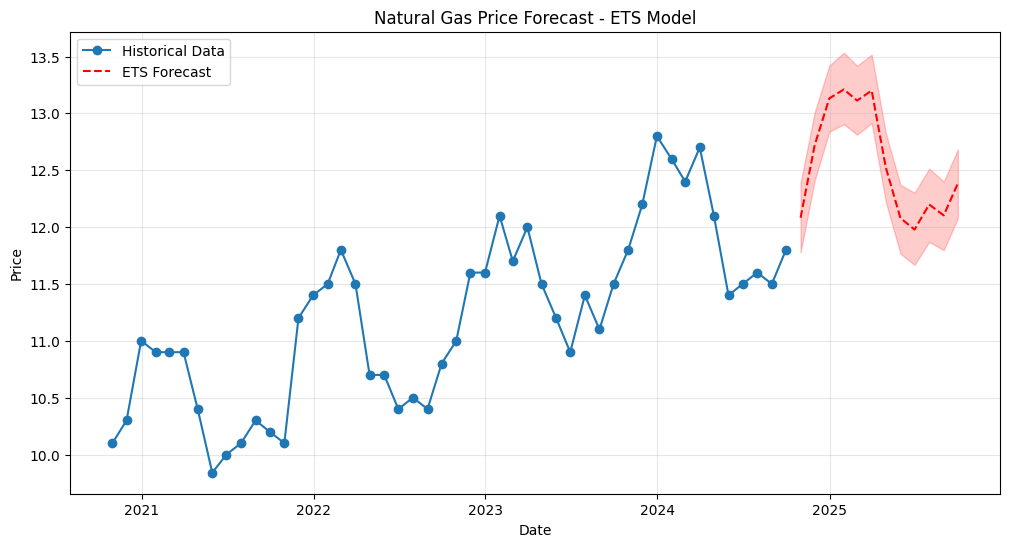


 ETS Model AIC: -5.060479418488299

Forecasted Prices (Next 12 Months):
                 mean
2024-10-31  12.081946
2024-11-30  12.721063
2024-12-31  13.131762
2025-01-31  13.210674
2025-02-28  13.112334
2025-03-31  13.200767
2025-04-30  12.524853
2025-05-31  12.079237
2025-06-30  11.978114
2025-07-31  12.199000
2025-08-31  12.103075
2025-09-30  12.384842


In [ ]:
# Fit ETS Model
ETS_model = ETSModel(df_month['Prices'],
                     error='add',
                     trend='add',
                     seasonal='mul',
                     seasonal_periods=12
                     )
ETS_result = ETS_model.fit()

# ETS Model forecast
ETS_forecast = ETS_result.get_prediction(start=df_month.index[-1] + timedelta(days=1),
                                         end=df_month.index[-1] + timedelta(days=365))
ETS_forecast_df = ETS_forecast.summary_frame()

# ETS Model forecast Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df_month.index, df_month['Prices'], label='Historical Data', marker='o', linestyle='-') # Plot Historical Data
plt.plot(ETS_forecast_df.index, ETS_forecast_df['mean'], label='ETS Forecast', color='red', linestyle='--') # Plot ETS Forecast
plt.fill_between(ETS_forecast_df.index, ETS_forecast_df['pi_lower'], ETS_forecast_df['pi_upper'],
                 color='red', alpha=0.2) # Plot Confidence Intervals
plt.title('Natural Gas Price Forecast - ETS Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Copy ETS forcast values in a dataframe
print("\n", "ETS Model AIC:", ETS_result.aic)
print("\nForecasted Prices (Next 12 Months):")
print(ETS_forecast_df[['mean']].head(12))

# Save ETS forcast values in a csv file
SARIMA_forecast_df[['mean']].head(12).to_csv('ETS_forecast.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Function: Estimate natural gas price for a given date
def estimate_gas_price(input_date, df_month=df_month, model=ETS_result):
    # Convert input date
    if isinstance(input_date, str):
        date = pd.to_datetime(input_date)
    else:
        date = input_date

    # If date exists in the historical dataset
    if date in df_month.index:
        return df_month.loc[date]

    # If date is before historical data
    if date < df_month.index.min():
        raise ValueError("Date is earlier than the available historical data.")

    # If date is after historical data (forecast needed)
    last_date = df_month.index[-1]

    # Generate forecasts up to requested date
    forecast = model.get_prediction(start=last_date + pd.offsets.MonthEnd(1),
                                    end=date + pd.offsets.MonthEnd(0))

    forecast_df = forecast.summary_frame()

    # Check if the requested date is in the forecast index
    forecast_index = forecast_df.index

    if date in forecast_index:
        return forecast_df.loc[date, "mean"]

    # If date falls within the same forecast month, return that value
    nearest = forecast_index.asof(date)
    return forecast_df.loc[nearest, "mean"]

## **Eample Usage**

In [ ]:
print(estimate_gas_price("2026-05-30"))

13.06355611326323


In [ ]:
print(estimate_gas_price("2022-02-28"))

Prices    11.8
Name: 2022-02-28 00:00:00, dtype: float64


In [ ]:
print(estimate_gas_price("2024-11-30"))

12.721062602576678


In [ ]:
print(estimate_gas_price("2025-06-15"))

12.07923674849343
